In [759]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from sklearn.metrics import accuracy_score
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D


import cv2
from pykuwahara import kuwahara

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity

from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)

In [1588]:
img_dir_test = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test_letters_images/'
img_dir_high_test = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test_high_resolution/'
img_dir_train = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train_letters_images/'
img_dir_high_train = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train_high_resolution/'
img_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/test_high_resolution/letter_bnw_test_65.jpg'
batch_size = 24

In [761]:
train_df = pd.read_csv('data_classifier/train.csv', header=None)
train_df

info_path_train = pd.DataFrame(train_df[196])
info_path_train["ID"] = info_path_train.index + 1
# info_path_train["External ID"] = ['image_' + str(x) + '.jpg' for x in info_path_train["ID"]]
info_path_train["External ID"] = ['letter_bnw_' + str(x) + '.jpg' for x in info_path_train["ID"]]
info_path_train["Description"] = info_path_train[196]
info_path_train['Description'] = [x for x in info_path_train['Description'].sort_values(ascending=False)]
info_path_train["Description"] = [int(x-1) for x in info_path_train["Description"]]
info_path_train = info_path_train.drop(columns=['ID', 196])
info_path_train

,External ID,Description
0,letter_bnw_1.jpg,23
1,letter_bnw_2.jpg,23
2,letter_bnw_3.jpg,23
3,letter_bnw_4.jpg,23
4,letter_bnw_5.jpg,23
...,...,...
235,letter_bnw_236.jpg,0
236,letter_bnw_237.jpg,0
237,letter_bnw_238.jpg,0
238,letter_bnw_239.jpg,0


In [762]:
test_df = pd.read_csv('data_classifier/test.csv', header=None)


info_path_test = pd.DataFrame(test_df[196])
info_path_test["ID"] = info_path_test.index + 1
# info_path_test["External ID"] = ['image_test_' + str(x) + '.jpg' for x in info_path_test["ID"]]
info_path_test["External ID"] = ['letter_bnw_test_' + str(x) + '.jpg' for x in info_path_test["ID"]]
info_path_test["Description"] = info_path_test[196]
# info_path_test['Description'] = [x for x in info_path_test['Description'].sort_values(ascending=False)]
info_path_test["Description"] = [int(x-1) for x in info_path_test["Description"]]
info_path_test = info_path_test.drop(columns=['ID', 196])
info_path_test

,External ID,Description
0,letter_bnw_test_1.jpg,0
1,letter_bnw_test_2.jpg,0
2,letter_bnw_test_3.jpg,0
3,letter_bnw_test_4.jpg,0
4,letter_bnw_test_5.jpg,1
...,...,...
91,letter_bnw_test_92.jpg,22
92,letter_bnw_test_93.jpg,23
93,letter_bnw_test_94.jpg,23
94,letter_bnw_test_95.jpg,23


In [763]:


# Define the image data generator and set the parameters for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=0.4,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    channel_shift_range=0.4,
    brightness_range=(0.4,0.6),
    fill_mode='nearest'
)


# Create separate generators for the training and validation sets
train_generator = datagen.flow_from_dataframe(
    dataframe=info_path_train,
    directory=img_dir_high_train,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
    
)

test_generator = datagen.flow_from_dataframe(
    dataframe=info_path_test,
    directory=img_dir_high_test,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
)

# # Define the model architecture

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SeparableConv2D(filters=60, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.SeparableConv2D(filters=120, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=16, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=32, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=256, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=512, activation=tf.nn.relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=24, activation=tf.nn.softmax))



# Compiling and optimizing model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Training the model
model.fit(train_generator, epochs=3000)

# # Evaluating the model
# val_loss, val_acc = model.evaluate(test_generator)
# print(val_loss)
# print(val_acc)

# Saving the model
model.save('handwritten_digits.model')

Found 240 validated image filenames.
Found 96 validated image filenames.


Epoch 1/6000
10/10 [==============================] - 4s 340ms/step - loss: 3.8936 - sparse_categorical_accuracy: 0.0333
Epoch 2/6000
10/10 [==============================] - 3s 299ms/step - loss: 4.0080 - sparse_categorical_accuracy: 0.0292
Epoch 3/6000
10/10 [==============================] - 3s 296ms/step - loss: 3.8934 - sparse_categorical_accuracy: 0.0417
Epoch 4/6000
10/10 [==============================] - 3s 296ms/step - loss: 3.6127 - sparse_categorical_accuracy: 0.0667
Epoch 5/6000
10/10 [==============================] - 3s 293ms/step - loss: 3.8059 - sparse_categorical_accuracy: 0.0458
Epoch 6/6000
10/10 [==============================] - 3s 292ms/step - loss: 3.6199 - sparse_categorical_accuracy: 0.0375
Epoch 7/6000
10/10 [==============================] - 3s 292ms/step - loss: 3.4553 - sparse_categorical_accuracy: 0.0708
Epoch 8/6000
10/10 [==============================] - 3s 288ms/step - loss: 3.6478 - sparse_categorical_accuracy: 0.0667
Epoch 9/6000
10/10 [============

INFO:tensorflow:Assets written to: handwritten_digits.model/assets


INFO:tensorflow:Assets written to: handwritten_digits.model/assets


In [1976]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.SeparableConv2D(filters=30, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.SeparableConv2D(filters=60, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.SeparableConv2D(filters=120, kernel_size=(3, 3), activation='relu'))
# # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(units=16, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(units=32, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(units=256, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(units=512, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(units=24, activation=tf.nn.softmax))

In [2256]:
model = tf.keras.models.load_model('handwritten_digits.model')

In [2362]:
val_loss, val_acc = model.evaluate(test_generator)
print(val_loss)
print(val_acc)

4/4 [==============================] - 1s 293ms/step - loss: 1.8945 - sparse_categorical_accuracy: 0.4479
1.894487738609314
0.4479166567325592


In [2257]:
single = info_path_test.iloc[info_path_test.index ==60]
single

,External ID,Description
60,letter_bnw_test_61.jpg,15


In [2258]:
test_generator_single = datagen.flow_from_dataframe(
    dataframe=single,
    directory=img_dir_high_test,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
)

Found 1 validated image filenames.


In [2259]:
image = cv2.imread('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg')

filt1 = kuwahara(image, method='mean', radius=4)
filt2 = kuwahara(image, method='gaussian', radius=4, sigma=1.5)

cv2.imwrite('lena-kfilt-mean_output.jpg', filt1)
cv2.imwrite('lena-kfilt-gaus_output.jpg', filt2)

path_output = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/lena-kfilt-gaus_output.jpg'
path_orig = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg'

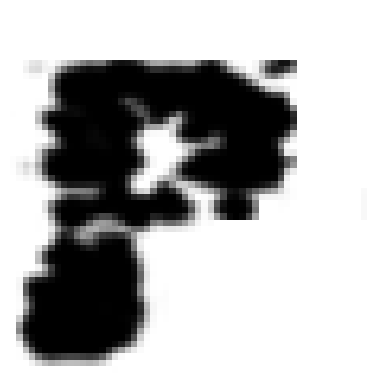

In [2352]:
# Open the image
# image = Image.open('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg')
path_filled = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/output_image_filled.jpg'


image = Image.open(path_filled) # path_filled

# Resize the image to 14x14
image = image.resize((66, 66))

# Convert the image to a numpy array
image_array = np.asarray(image)

# Invert the pixel values
image_array = (image_array / 255.0)

image_array = color.rgb2gray(image_array)

image_array[35:66, 40:66] = 1
image_array[0:10, 0:66] = 1
image_array[0:30, 53:66] = 1

# Display the inverted image
plt.imshow(image_array[2:60,8:64], cmap='gray')
plt.axis('off')
plt.savefig('output_image_enhanced.jpg')
plt.savefig('output_image_enhanced_iterate_0.jpg')

plt.show()


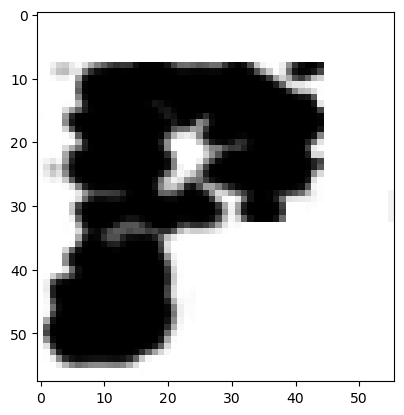

In [2353]:
image_filled = rescale_intensity(image_array[2:60,8:64], in_range=(0, 1))

seed = np.copy(image_filled)
seed[1:-1, 1:-1] = image_filled.max()
mask_local = image_filled

filled = reconstruction(seed, mask_local, method='erosion', footprint=square(5))

seed = np.copy(image_filled)
seed[1:-1, 1:-1] = image_filled.min()
rec = reconstruction(seed, mask_local, method='dilation', footprint=square(5))

holes_array = (image_filled - rec)
height, width = holes_array.shape

# Create a new image with double the dimensions
new_height, new_width = height * 1, width * 1

holes_array = cv2.resize(holes_array, (new_width, new_height))

holes_array = 1 - np.where(holes_array > 0, 1, 0)

image_result = inpaint.inpaint_biharmonic(image_filled, (1 - holes_array))**2


plt.imshow(image_result, cmap='gray')

plt.savefig('output_image_filled.jpg', bbox_inches='tight')



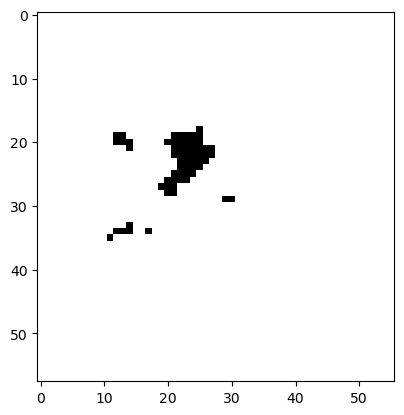

In [2354]:
plt.imshow(holes_array, cmap='gray')

In [2355]:
test_img = info_path_test.iloc[info_path_test.index == 67]
test_img['External ID'] = ['output_image_filled.jpg' for x in test_img['External ID']]
test_img

/var/folders/1n/svcs5g6s7mv0fpm0vy7nq6y00000gn/T/ipykernel_1909/977294992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_img['External ID'] = ['output_image_filled.jpg' for x in test_img['External ID']]


,External ID,Description
67,output_image_filled.jpg,16


In [2356]:
test_generator_output = datagen.flow_from_dataframe(
    dataframe=test_img,
    directory='/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/' ,
    x_col="External ID",
    y_col="Description",
    target_size=(66, 66),
    batch_size=batch_size,
    class_mode='raw',
    shuffle = True
)

Found 1 validated image filenames.


In [2357]:
pred_probs = model.predict(test_generator_output)
print(pred_probs)
# Get the predicted class label
pred_label = np.argmax(pred_probs)
print(pred_label)


# if pred_label == 1:
#     pred_label = 1
# elif pred_label == 2:
#     pred_label = 10
# elif pred_label == 3:
#     pred_label = 11
# elif pred_label == 4:
#     pred_label = 12
# elif pred_label == 5:
#     pred_label = 13
# elif pred_label == 6:
#     pred_label = 14
# elif pred_label == 7:
#     pred_label = 15
# elif pred_label == 8:
#     pred_label = 16
# elif pred_label == 9:
#     pred_label = 17
# elif pred_label == 10:
#     pred_label = 18
# elif pred_label == 11:
#     pred_label = 19
# elif pred_label == 12:
#     pred_label = 2
# elif pred_label == 13:
#     pred_label = 20
# elif pred_label == 14:
#     pred_label = 21
# elif pred_label == 15:
#     pred_label = 22
# elif pred_label == 16:
#     pred_label = 23
# elif pred_label == 17:
#     pred_label = 24
# elif pred_label == 18:
#     pred_label = 3
# elif pred_label == 19:
#     pred_label = 4
# elif pred_label == 20:
#     pred_label = 5
# elif pred_label == 21:
#     pred_label = 6
# elif pred_label == 22:
#     pred_label = 7
# elif pred_label == 23:
#     pred_label = 8
# else:
#     pred_label = 9
    
print("The predicted class is:", pred_label)



1/1 [==============================] - 0s 34ms/step
[[1.2648566e-05 4.7833869e-06 1.5219400e-05 3.1569134e-06 5.0348714e-03
  2.2851648e-03 3.4935471e-02 2.1990867e-05 1.0333289e-05 2.4024083e-03
  4.9066782e-04 4.1595367e-03 2.5705491e-05 5.9635371e-01 6.5035533e-09
  3.5858371e-03 9.1886886e-06 5.6343852e-06 2.8874461e-05 1.1524621e-06
  1.6966354e-02 5.5531277e-03 3.2604131e-01 2.0528683e-03]]
13
The predicted class is: 13


letter_bnw_101.jpg


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

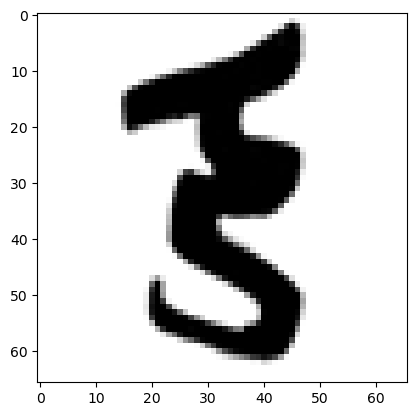

In [2358]:
neural_pull = info_path_train.loc[info_path_train['Description'] == pred_label]
neural_pull = neural_pull['External ID'].iloc[0]
print(neural_pull)

neural_pull_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/data_classifier/train_high_resolution/' + neural_pull
neural_pull_path


image_pull = Image.open(neural_pull_path)
# Resize the image to 14x14
image_pull = image_pull.resize((66, 66))

# Convert the image to a numpy array
image_pull = np.asarray(image_pull)

display(image_pull)
# Invert the pixel values
image_pull = (image_pull / 255.0)
plt.imshow(image_pull, cmap='gray')

In [2359]:
test_img

,External ID,Description
67,output_image_filled.jpg,16


output_image_filled.jpg


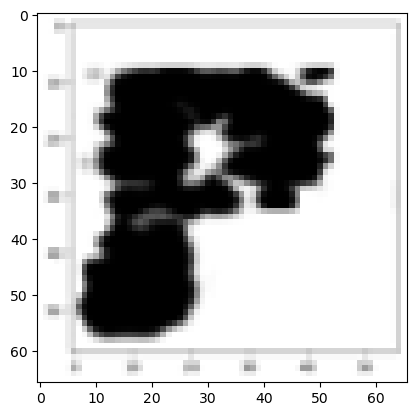

In [2360]:
test_pull = info_path_test.loc[info_path_test['Description'] == pred_label]
test_pull = test_img['External ID'].iloc[0]
print(test_pull)

# data_classifier/test_high_resolution/

test_pull_path = '/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/classifier_ai_letters/' + test_pull
test_pull_path

test_image_pull = Image.open(test_pull_path)
# Resize the image to 14x14
test_image_pull = test_image_pull.resize((66, 66))


# Convert the image to a numpy array
test_image_pull = np.asarray(test_image_pull)

# test_image_pull = color.rgb2gray(test_image_pull)

# Invert the pixel values
test_image_pull = (test_image_pull / 255.0)
display(plt.imshow(test_image_pull, cmap='gray'))

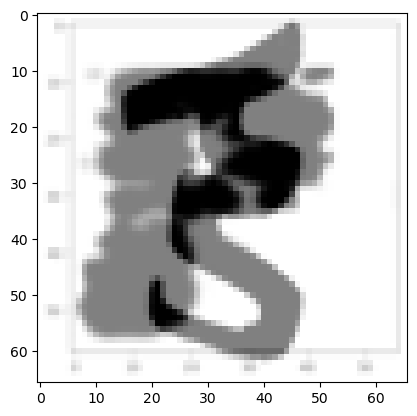

In [2361]:
# display(plt.imshow(test_image_pull + image_pull, cmap='gray'))

# assume test_image_pull is a 3D numpy array of shape (height, width, 3)
gray_image_pull = np.mean(test_image_pull, axis=-1)

plt.imshow(gray_image_pull + image_pull, cmap='gray')


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


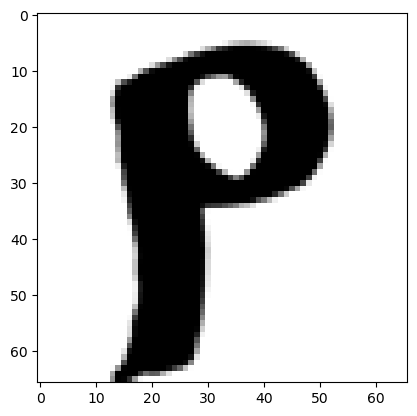

In [2363]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Open the image
# image = Image.open('/Users/andrebarle/Documents/Flatiron_Work/phase_5/papyrus_ink_detection/notebooks/output_image.jpg')
image = Image.open(img_path).convert('L')
# Resize the image to 14x14
image = image.resize((66, 66))

# Convert the image to a numpy array
image_array = np.asarray(image)

# Invert the pixel values
image_array = image_array / 255.0

mask = []
for i in range(0,len(image_array)):
    mask_layer = [0 if 'False' else 1 for x in image_array[i]]
    mask.append(mask_layer)

mask = np.array(mask)


mask[35:66, 40:66] = 1
print(mask)

# image_array = [0 if 1 in mask else x for x in image_array]

image_defect = image_array
# image_defect[35:66, 40:66] = 1

# Display the inverted image
plt.imshow(image_defect, cmap='gray')
plt.show()
